### HAM10000 Skin Lesion Classification Project

This project aims to build a deep learning model (ResNet) for skin lesion classification using the [HAM10000 dataset](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000). The dataset includes 10,015 dermatoscopic images from seven classes:

- **akiec (327)**: Actinic keratoses and intraepithelial carcinoma
- **bcc (514)**: Basal cell carcinoma
- **bkl (1099)**: Benign keratosis-like lesions
- **df (115)**: Dermatofibroma
- **mel (1113)**: Melanoma
- **nv (6075)**: Melanocytic nevi
- **vasc (142)**: Vascular lesions


**Result for test set data**

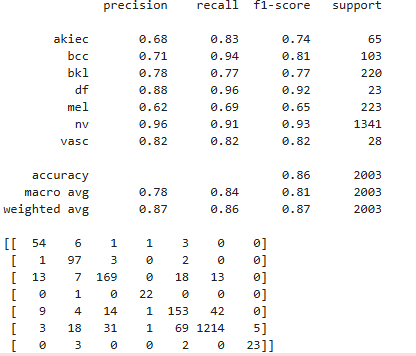

In [1]:
from pathlib import Path
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split

root_path = "C:/Users/cylo2/anaconda3/envs/py3110/projects/kaggle/cancer/source"

# Output split file paths
trainval_split_path = f'{root_path}/trainval_images.csv'
test_split_path = f'{root_path}/test_images.csv'

# Check if splits already exist
if os.path.exists(trainval_split_path) and os.path.exists(test_split_path):
    print("Split files found, loading splits...")
    trainval_df = pd.read_csv(trainval_split_path)
    test_df = pd.read_csv(test_split_path)
else:
    print("No split files found. Creating new split...")

    # 1. Find all jpg images in both subfolders
    all_images = glob.glob(os.path.join(root_path, 'HAM10000_images_part_*', '*.jpg'))

    # 2. Make a dict: image_id -> full path
    image_id_to_path = {}
    for path in all_images:
        image_id = os.path.splitext(os.path.basename(path))[0]
        image_id_to_path[image_id] = str(Path(path).as_posix())

    # 3. Load metadata and add image_path column
    meta = pd.read_csv(f'{root_path}/HAM10000_metadata.csv')
    meta['image_path'] = meta['image_id'].map(image_id_to_path)

    # Optional: Save the updated metadata
    meta.to_csv(f'{root_path}/HAM10000_metadata_with_path.csv', index=False)

    # 4. Split: 80% for train+val (for k-fold), 20% as fixed test set
    X = meta['image_id']
    y = meta['dx']

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 5. Create DataFrames (keeping all columns, including image_path)
    trainval_df = meta[meta['image_id'].isin(X_trainval)]
    test_df = meta[meta['image_id'].isin(X_test)]

    # 6. Save splits (with image_path included)
    trainval_df.to_csv(trainval_split_path, index=False)
    test_df.to_csv(test_split_path, index=False)

    print('Splitting complete!')
    print(f"Train/Val set: {len(trainval_df)} images")
    print(f"Test set:     {len(test_df)} images")

# Now you can use trainval_df and test_df for the rest of your workflow
print(f"Train/Val set: {len(trainval_df)} images loaded")
print(f"Test set:     {len(test_df)} images loaded")

print("\nClass distribution in train/val set:")
class_counts = trainval_df['dx'].value_counts()
print(class_counts)

Split files found, loading splits...
Train/Val set: 8012 images loaded
Test set:     2003 images loaded

Class distribution in train/val set:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64


In [2]:
# Standard library imports
import random

# Third-party imports
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim


# Torchvision imports
from torchvision import transforms, models

In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            logpt = logpt * at
        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((168, 224)),
    transforms.Pad((0, 28, 0, 28), padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(
        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((168, 224)),
    transforms.Pad((0, 28, 0, 28), padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

aggressive_train_transforms  = transforms.Compose([
    transforms.Resize((168, 224)),
    transforms.Pad((0, 28, 0, 28), padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.12, 0.12), scale=(0.88, 1.12)),
    #transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
label_list = sorted(trainval_df['dx'].unique())

class HAM10000Dataset(Dataset):
    def __init__(self, df, transform=None, label_list=None, aggressive_transform=None, aggressive_classes=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_list = label_list
        self.label2idx = {label: idx for idx, label in enumerate(self.label_list)}
        self.aggressive_transform = aggressive_transform
        self.aggressive_classes = set(aggressive_classes) if aggressive_classes else set()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        # Use aggressive transform if class matches
        if self.aggressive_transform and row['dx'] in self.aggressive_classes:
            img = self.aggressive_transform(img)
        elif self.transform:
            img = self.transform(img)
        label = self.label2idx[row['dx']]
        return img, label

In [6]:
upsample_map = {
    'nv': 5364,   
    'mel': 1200,   
    'bkl': 1200,   
    'bcc': 800,
    'akiec': 800,
    'vasc': 300,
    'df': 300
}

def upsample_classes(df, upsample_map):
    dfs = []
    for cls in df['dx'].unique():
        cls_df = df[df['dx'] == cls]
        n_samples = upsample_map.get(cls, len(cls_df))
        dfs.append(cls_df.sample(n_samples, replace=True, random_state=42))
    return pd.concat(dfs).reset_index(drop=True)

trainval_df_upsampled = upsample_classes(trainval_df, upsample_map)

In [7]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

targets = trainval_df_upsampled['dx']
folds = list(skf.split(trainval_df_upsampled, targets))

In [8]:
def get_sampler(df):
    class_counts = df['dx'].value_counts()
    class_weights = 1. / class_counts
    weights = df['dx'].map(class_weights)
    sampler = WeightedRandomSampler(weights.values, len(weights))
    return sampler

In [9]:
def get_loaders(train_idx, val_idx, label_list):
    train_df = trainval_df_upsampled.iloc[train_idx]
    val_df = trainval_df_upsampled.iloc[val_idx]

    train_dataset = HAM10000Dataset(
        train_df,
        transform=train_transforms,
        label_list=label_list,
        aggressive_transform=aggressive_train_transforms,
    )
    val_dataset = HAM10000Dataset(val_df, transform=val_transforms, label_list=label_list)

    train_loader = DataLoader(
        #train_dataset, batch_size=64, sampler=get_sampler(train_df), num_workers=0)
        train_dataset, batch_size=64, shuffle=True,num_workers=0)
    val_loader = DataLoader(
        val_dataset, batch_size=64, shuffle=False, num_workers=0)
    return train_loader, val_loader

In [10]:
def get_model(num_classes):
    model = models.resnet50(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_list)

def compute_class_weights(train_idx, df, label_list, device):
    train_labels = df.iloc[train_idx]['dx']
    class_sample_counts = train_labels.value_counts().reindex(label_list, fill_value=0)
    class_weights = 1. / np.where(class_sample_counts.values == 0, 1, class_sample_counts.values)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    return class_weights_tensor

def evaluate(model, val_loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(val_loader.dataset)
    acc = correct / total
    return avg_loss, acc, np.array(all_preds), np.array(all_labels)

for fold, (train_idx, val_idx) in enumerate(folds):
    print(f'Fold {fold+1}/{n_splits}')
    train_loader, val_loader = get_loaders(train_idx, val_idx, label_list)
    model = get_model(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
    class_weights_tensor = compute_class_weights(train_idx, trainval_df_upsampled, label_list, device)
    criterion = FocalLoss(alpha=class_weights_tensor, gamma=1)

    best_acc = 0
    patience_counter = 0
    for epoch in range(1, 11):
        print(f"Epoch {epoch}")
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Training Fold {fold+1} Epoch {epoch}", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, device, criterion)
        scheduler.step(val_acc)
        print(f"Fold {fold+1} Epoch {epoch}: Train Loss={epoch_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
        print(classification_report(
            val_labels, val_preds, target_names=label_list, digits=4
        ))
        print("Confusion Matrix:")
        print(confusion_matrix(val_labels, val_preds))

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f"{root_path}/best_model_fold{fold+1}.pt")
        else:
          patience_counter += 1
          if patience_counter >= 5:
              print("Early stopping triggered")
              break
    print(f"Best val acc for fold {fold+1}: {best_acc:.4f}")


Fold 1/5
Epoch 1


Fold 1 Epoch 1: Train Loss=0.0006, Val Loss=0.0004, Val Acc=0.6774
              precision    recall  f1-score   support

       akiec     0.6133    0.6937    0.6510       160
         bcc     0.6651    0.8688    0.7534       160
         bkl     0.7063    0.4208    0.5274       240
          df     0.3896    1.0000    0.5607        60
         mel     0.3604    0.7958    0.4961       240
          nv     0.9732    0.6421    0.7737      1073
        vasc     0.8676    0.9833    0.9219        60

    accuracy                         0.6774      1993
   macro avg     0.6536    0.7721    0.6692      1993
weighted avg     0.7929    0.6774    0.6972      1993

Confusion Matrix:
[[111  19   4  14  11   1   0]
 [  9 139   0   7   4   1   0]
 [ 37  18 101  23  50   9   2]
 [  0   0   0  60   0   0   0]
 [ 18   9   8   3 191   8   3]
 [  6  24  30  46 274 689   4]
 [  0   0   0   1   0   0  59]]
Epoch 2


Fold 1 Epoch 2: Train Loss=0.0003, Val Loss=0.0003, Val Acc=0.7873
              precision    recall  f1-score   support

       akiec     0.8425    0.6687    0.7456       160
         bcc     0.6711    0.9437    0.7844       160
         bkl     0.7383    0.6583    0.6960       240
          df     0.9310    0.9000    0.9153        60
         mel     0.4896    0.6875    0.5719       240
          nv     0.9311    0.8183    0.8710      1073
        vasc     0.6292    0.9333    0.7517        60

    accuracy                         0.7873      1993
   macro avg     0.7476    0.8014    0.7623      1993
weighted avg     0.8176    0.7873    0.7947      1993

Confusion Matrix:
[[107  18  27   2   1   5   0]
 [  1 151   1   0   3   3   1]
 [  4  19 158   1  32  26   0]
 [  0   3   0  54   2   1   0]
 [  8  11  12   0 165  30  14]
 [  7  19  16   1 134 878  18]
 [  0   4   0   0   0   0  56]]
Epoch 3


Fold 1 Epoch 3: Train Loss=0.0003, Val Loss=0.0003, Val Acc=0.7712
              precision    recall  f1-score   support

       akiec     0.8224    0.7812    0.8013       160
         bcc     0.7018    0.9563    0.8095       160
         bkl     0.4769    0.9042    0.6245       240
          df     0.7051    0.9167    0.7971        60
         mel     0.6933    0.4708    0.5608       240
          nv     0.9544    0.7605    0.8465      1073
        vasc     0.8056    0.9667    0.8788        60

    accuracy                         0.7712      1993
   macro avg     0.7371    0.8223    0.7598      1993
weighted avg     0.8226    0.7712    0.7782      1993

Confusion Matrix:
[[125  12  20   1   2   0   0]
 [  5 153   2   0   0   0   0]
 [  5  10 217   1   1   6   0]
 [  0   5   0  55   0   0   0]
 [ 10  18  61   0 113  33   5]
 [  7  18 155  21  47 816   9]
 [  0   2   0   0   0   0  58]]
Epoch 4


Fold 1 Epoch 4: Train Loss=0.0002, Val Loss=0.0004, Val Acc=0.6558
              precision    recall  f1-score   support

       akiec     0.8023    0.8625    0.8313       160
         bcc     0.8644    0.6375    0.7338       160
         bkl     0.3289    0.9250    0.4852       240
          df     0.7632    0.9667    0.8529        60
         mel     0.4828    0.5250    0.5030       240
          nv     0.9836    0.5601    0.7138      1073
        vasc     0.7500    1.0000    0.8571        60

    accuracy                         0.6558      1993
   macro avg     0.7107    0.7824    0.7110      1993
weighted avg     0.8067    0.6558    0.6804      1993

Confusion Matrix:
[[138   0  20   0   2   0   0]
 [ 20 102  19   6  10   0   3]
 [  8   0 222   1   7   2   0]
 [  0   0   2  58   0   0   0]
 [  1   1 102   0 126   8   2]
 [  5  15 310  11 116 601  15]
 [  0   0   0   0   0   0  60]]
Epoch 5


Fold 1 Epoch 5: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.7652
              precision    recall  f1-score   support

       akiec     0.6375    0.9563    0.7650       160
         bcc     0.8036    0.8438    0.8232       160
         bkl     0.6655    0.8042    0.7283       240
          df     0.7500    0.8000    0.7742        60
         mel     0.4793    0.8208    0.6052       240
          nv     0.9880    0.6887    0.8116      1073
        vasc     0.8333    1.0000    0.9091        60

    accuracy                         0.7652      1993
   macro avg     0.7367    0.8448    0.7738      1993
weighted avg     0.8331    0.7652    0.7757      1993

Confusion Matrix:
[[153   1   3   0   3   0   0]
 [ 15 135   7   1   2   0   0]
 [ 30   2 193   1  12   2   0]
 [  8   0   3  48   1   0   0]
 [ 10   7  13   1 197   7   5]
 [ 24  23  71  13 196 739   7]
 [  0   0   0   0   0   0  60]]
Epoch 6


Fold 1 Epoch 6: Train Loss=0.0001, Val Loss=0.0002, Val Acc=0.8761
              precision    recall  f1-score   support

       akiec     0.7800    0.9750    0.8667       160
         bcc     0.8457    0.8562    0.8509       160
         bkl     0.9198    0.8125    0.8628       240
          df     0.9194    0.9500    0.9344        60
         mel     0.6335    0.8500    0.7260       240
          nv     0.9640    0.8742    0.9169      1073
        vasc     0.9516    0.9833    0.9672        60

    accuracy                         0.8761      1993
   macro avg     0.8591    0.9002    0.8750      1993
weighted avg     0.8929    0.8761    0.8801      1993

Confusion Matrix:
[[156   0   3   0   1   0   0]
 [ 14 137   1   0   3   5   0]
 [ 13   6 195   2  17   7   0]
 [  3   0   0  57   0   0   0]
 [  7   2   2   0 204  23   2]
 [  7  16  11   3  97 938   1]
 [  0   1   0   0   0   0  59]]
Epoch 7


Fold 1 Epoch 7: Train Loss=0.0001, Val Loss=0.0001, Val Acc=0.8846
              precision    recall  f1-score   support

       akiec     0.8807    0.9688    0.9226       160
         bcc     0.8471    0.9000    0.8727       160
         bkl     0.9492    0.7792    0.8558       240
          df     0.8571    1.0000    0.9231        60
         mel     0.6435    0.8500    0.7325       240
          nv     0.9559    0.8882    0.9208      1073
        vasc     0.9091    1.0000    0.9524        60

    accuracy                         0.8846      1993
   macro avg     0.8632    0.9123    0.8828      1993
weighted avg     0.8983    0.8846    0.8876      1993

Confusion Matrix:
[[155   0   0   1   2   2   0]
 [  6 144   2   1   2   5   0]
 [  6   7 187   3  28   9   0]
 [  0   0   0  60   0   0   0]
 [  2   5   0   0 204  28   1]
 [  7  14   8   5  81 953   5]
 [  0   0   0   0   0   0  60]]
Epoch 8


Fold 1 Epoch 8: Train Loss=0.0001, Val Loss=0.0002, Val Acc=0.8530
              precision    recall  f1-score   support

       akiec     0.8814    0.9750    0.9258       160
         bcc     0.8297    0.9437    0.8830       160
         bkl     0.8952    0.7833    0.8356       240
          df     0.9048    0.9500    0.9268        60
         mel     0.5506    0.8833    0.6784       240
          nv     0.9595    0.8173    0.8827      1073
        vasc     0.9516    0.9833    0.9672        60

    accuracy                         0.8530      1993
   macro avg     0.8533    0.9052    0.8714      1993
weighted avg     0.8840    0.8530    0.8598      1993

Confusion Matrix:
[[156   2   2   0   0   0   0]
 [  5 151   0   0   1   3   0]
 [  4  12 188   2  17  17   0]
 [  2   0   1  57   0   0   0]
 [  1   4   5   0 212  16   2]
 [  9  13  14   4 155 877   1]
 [  0   0   0   0   0   1  59]]
Epoch 9


Fold 1 Epoch 9: Train Loss=0.0001, Val Loss=0.0002, Val Acc=0.8630
              precision    recall  f1-score   support

       akiec     0.7685    0.9750    0.8595       160
         bcc     0.7525    0.9313    0.8324       160
         bkl     0.7428    0.8542    0.7946       240
          df     0.7407    1.0000    0.8511        60
         mel     0.7936    0.7208    0.7555       240
          nv     0.9642    0.8546    0.9061      1073
        vasc     0.9091    1.0000    0.9524        60

    accuracy                         0.8630      1993
   macro avg     0.8102    0.9051    0.8502      1993
weighted avg     0.8759    0.8630    0.8646      1993

Confusion Matrix:
[[156   0   3   1   0   0   0]
 [  7 149   0   3   0   1   0]
 [  5  14 205   3   9   4   0]
 [  0   0   0  60   0   0   0]
 [ 17  10   7   0 173  29   4]
 [ 18  25  61  14  36 917   2]
 [  0   0   0   0   0   0  60]]
Epoch 10


Fold 1 Epoch 10: Train Loss=0.0001, Val Loss=0.0002, Val Acc=0.8741
              precision    recall  f1-score   support

       akiec     0.8432    0.9750    0.9043       160
         bcc     0.7989    0.8938    0.8437       160
         bkl     0.7660    0.9000    0.8276       240
          df     0.8235    0.9333    0.8750        60
         mel     0.7143    0.8542    0.7780       240
          nv     0.9763    0.8453    0.9061      1073
        vasc     0.9365    0.9833    0.9593        60

    accuracy                         0.8741      1993
   macro avg     0.8370    0.9121    0.8706      1993
weighted avg     0.8887    0.8741    0.8767      1993

Confusion Matrix:
[[156   2   2   0   0   0   0]
 [  8 143   3   0   2   4   0]
 [  7   6 216   2   4   5   0]
 [  0   2   2  56   0   0   0]
 [  3   4  13   2 205  13   0]
 [ 11  21  46   8  76 907   4]
 [  0   1   0   0   0   0  59]]
Best val acc for fold 1: 0.8846
Fold 2/5
Epoch 1


Fold 2 Epoch 1: Train Loss=0.0006, Val Loss=0.0004, Val Acc=0.7090
              precision    recall  f1-score   support

       akiec     0.5751    0.8375    0.6819       160
         bcc     0.6335    0.8750    0.7349       160
         bkl     0.5471    0.6292    0.5853       240
          df     0.3563    0.9500    0.5182        60
         mel     0.5054    0.5833    0.5416       240
          nv     0.9721    0.6831    0.8024      1073
        vasc     0.8056    0.9667    0.8788        60

    accuracy                         0.7090      1993
   macro avg     0.6279    0.7893    0.6776      1993
weighted avg     0.7821    0.7090    0.7235      1993

Confusion Matrix:
[[134  18   2   3   3   0   0]
 [  5 140   0  13   1   0   1]
 [ 35  14 151  14  14  11   1]
 [  2   1   0  57   0   0   0]
 [ 32  17  32   7 140  10   2]
 [ 25  29  91  66 119 733  10]
 [  0   2   0   0   0   0  58]]
Epoch 2


Fold 2 Epoch 2: Train Loss=0.0003, Val Loss=0.0003, Val Acc=0.7807
              precision    recall  f1-score   support

       akiec     0.7807    0.9125    0.8415       160
         bcc     0.8084    0.8438    0.8257       160
         bkl     0.6200    0.6458    0.6327       240
          df     0.9643    0.9000    0.9310        60
         mel     0.4930    0.8833    0.6328       240
          nv     0.9790    0.7400    0.8429      1073
        vasc     0.6522    1.0000    0.7895        60

    accuracy                         0.7807      1993
   macro avg     0.7568    0.8465    0.7852      1993
weighted avg     0.8374    0.7807    0.7918      1993

Confusion Matrix:
[[146   5   2   0   7   0   0]
 [  7 135   6   0   2   1   9]
 [ 23  10 155   0  44   7   1]
 [  2   1   2  54   0   1   0]
 [  4   3  12   0 212   8   1]
 [  5  13  73   2 165 794  21]
 [  0   0   0   0   0   0  60]]
Epoch 3


Fold 2 Epoch 3: Train Loss=0.0003, Val Loss=0.0003, Val Acc=0.7416
              precision    recall  f1-score   support

       akiec     0.7105    0.8438    0.7714       160
         bcc     0.7196    0.8500    0.7794       160
         bkl     0.5927    0.7458    0.6605       240
          df     0.3806    0.9833    0.5488        60
         mel     0.6082    0.6208    0.6144       240
          nv     0.9682    0.7083    0.8181      1073
        vasc     0.4724    1.0000    0.6417        60

    accuracy                         0.7416      1993
   macro avg     0.6360    0.8217    0.6906      1993
weighted avg     0.8063    0.7416    0.7543      1993

Confusion Matrix:
[[135  12   5   6   2   0   0]
 [  5 136   4  10   0   1   4]
 [ 18   8 179   9  13   7   6]
 [  1   0   0  59   0   0   0]
 [ 11  14  32  11 149  17   6]
 [ 20  19  82  60  81 760  51]
 [  0   0   0   0   0   0  60]]
Epoch 4


Fold 2 Epoch 4: Train Loss=0.0003, Val Loss=0.0002, Val Acc=0.8440
              precision    recall  f1-score   support

       akiec     0.7903    0.9187    0.8497       160
         bcc     0.8365    0.8313    0.8339       160
         bkl     0.6581    0.8500    0.7418       240
          df     0.9661    0.9500    0.9580        60
         mel     0.6612    0.6667    0.6639       240
          nv     0.9544    0.8583    0.9038      1073
        vasc     0.8333    1.0000    0.9091        60

    accuracy                         0.8440      1993
   macro avg     0.8143    0.8679    0.8372      1993
weighted avg     0.8575    0.8440    0.8473      1993

Confusion Matrix:
[[147   3   5   0   4   1   0]
 [ 15 133   6   1   0   4   1]
 [ 11   4 204   0   9  12   0]
 [  1   0   1  57   0   1   0]
 [  6   6  41   0 160  26   1]
 [  6  13  53   1  69 921  10]
 [  0   0   0   0   0   0  60]]
Epoch 5


Fold 2 Epoch 5: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.7963
              precision    recall  f1-score   support

       akiec     0.6636    0.9125    0.7684       160
         bcc     0.9296    0.8250    0.8742       160
         bkl     0.6051    0.7917    0.6859       240
          df     0.4603    0.9667    0.6237        60
         mel     0.6856    0.5542    0.6129       240
          nv     0.9425    0.8089    0.8706      1073
        vasc     0.7895    1.0000    0.8824        60

    accuracy                         0.7963      1993
   macro avg     0.7252    0.8370    0.7597      1993
weighted avg     0.8284    0.7963    0.8023      1993

Confusion Matrix:
[[146   3   5   6   0   0   0]
 [  6 132   2  14   0   2   4]
 [ 22   3 190   0  11  13   1]
 [  1   0   0  58   0   1   0]
 [ 22   0  34  12 133  37   2]
 [ 23   4  83  36  50 868   9]
 [  0   0   0   0   0   0  60]]
Epoch 6


Fold 2 Epoch 6: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8419
              precision    recall  f1-score   support

       akiec     0.7123    0.9750    0.8232       160
         bcc     0.8371    0.9313    0.8817       160
         bkl     0.7500    0.5500    0.6346       240
          df     0.9048    0.9500    0.9268        60
         mel     0.6469    0.7708    0.7034       240
          nv     0.9456    0.8751    0.9090      1073
        vasc     0.7692    1.0000    0.8696        60

    accuracy                         0.8419      1993
   macro avg     0.7951    0.8646    0.8212      1993
weighted avg     0.8521    0.8419    0.8415      1993

Confusion Matrix:
[[156   0   0   0   2   2   0]
 [  6 149   1   0   0   2   2]
 [ 40   4 132   0  41  21   2]
 [  2   1   0  57   0   0   0]
 [  9   6  10   0 185  29   1]
 [  6  18  33   6  58 939  13]
 [  0   0   0   0   0   0  60]]
Epoch 7


Fold 2 Epoch 7: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.8033
              precision    recall  f1-score   support

       akiec     0.8026    0.7625    0.7821       160
         bcc     0.7514    0.8313    0.7893       160
         bkl     0.6836    0.7292    0.7056       240
          df     0.7808    0.9500    0.8571        60
         mel     0.5296    0.8583    0.6550       240
          nv     0.9726    0.7931    0.8737      1073
        vasc     0.8028    0.9500    0.8702        60

    accuracy                         0.8033      1993
   macro avg     0.7605    0.8392    0.7904      1993
weighted avg     0.8421    0.8033    0.8124      1993

Confusion Matrix:
[[122  13  19   0   6   0   0]
 [  1 133  11   2   9   0   4]
 [ 13   6 175   2  28  16   0]
 [  0   2   0  57   1   0   0]
 [  3   1  20   1 206   8   1]
 [ 13  19  31  11 139 851   9]
 [  0   3   0   0   0   0  57]]
Epoch 8


Fold 2 Epoch 8: Train Loss=0.0001, Val Loss=0.0001, Val Acc=0.8821
              precision    recall  f1-score   support

       akiec     0.9074    0.9187    0.9130       160
         bcc     0.7488    0.9688    0.8447       160
         bkl     0.9095    0.7542    0.8246       240
          df     0.9365    0.9833    0.9593        60
         mel     0.6766    0.8542    0.7551       240
          nv     0.9529    0.8863    0.9184      1073
        vasc     0.9836    1.0000    0.9917        60

    accuracy                         0.8821      1993
   macro avg     0.8736    0.9094    0.8867      1993
weighted avg     0.8948    0.8821    0.8845      1993

Confusion Matrix:
[[147  11   0   0   2   0   0]
 [  1 155   2   0   0   2   0]
 [  7  12 181   1  17  22   0]
 [  0   1   0  59   0   0   0]
 [  3   4   3   1 205  23   1]
 [  4  24  13   2  79 951   0]
 [  0   0   0   0   0   0  60]]
Epoch 9


Fold 2 Epoch 9: Train Loss=0.0001, Val Loss=0.0001, Val Acc=0.8936
              precision    recall  f1-score   support

       akiec     0.7560    0.9875    0.8564       160
         bcc     0.8588    0.9500    0.9021       160
         bkl     0.8488    0.7250    0.7820       240
          df     0.9836    1.0000    0.9917        60
         mel     0.7297    0.9000    0.8060       240
          nv     0.9766    0.8956    0.9344      1073
        vasc     0.9836    1.0000    0.9917        60

    accuracy                         0.8936      1993
   macro avg     0.8767    0.9226    0.8949      1993
weighted avg     0.9047    0.8936    0.8952      1993

Confusion Matrix:
[[158   2   0   0   0   0   0]
 [  4 152   0   0   0   4   0]
 [ 26   9 174   0  23   8   0]
 [  0   0   0  60   0   0   0]
 [  2   3   6   1 216  11   1]
 [ 19  11  25   0  57 961   0]
 [  0   0   0   0   0   0  60]]
Epoch 10


Fold 2 Epoch 10: Train Loss=0.0001, Val Loss=0.0001, Val Acc=0.9052
              precision    recall  f1-score   support

       akiec     0.8785    0.9938    0.9326       160
         bcc     0.8571    0.9375    0.8955       160
         bkl     0.7852    0.8833    0.8314       240
          df     0.9672    0.9833    0.9752        60
         mel     0.7975    0.8042    0.8008       240
          nv     0.9681    0.9049    0.9355      1073
        vasc     0.9836    1.0000    0.9917        60

    accuracy                         0.9052      1993
   macro avg     0.8910    0.9296    0.9090      1993
weighted avg     0.9099    0.9052    0.9062      1993

Confusion Matrix:
[[159   0   1   0   0   0   0]
 [  5 150   2   0   0   3   0]
 [  5   9 212   0   4  10   0]
 [  0   0   1  59   0   0   0]
 [  6   1  19   1 193  19   1]
 [  6  15  35   1  45 971   0]
 [  0   0   0   0   0   0  60]]
Best val acc for fold 2: 0.9052
Fold 3/5
Epoch 1


Fold 3 Epoch 1: Train Loss=0.0006, Val Loss=0.0004, Val Acc=0.7135
              precision    recall  f1-score   support

       akiec     0.5069    0.9187    0.6533       160
         bcc     0.6500    0.7312    0.6882       160
         bkl     0.5972    0.5250    0.5588       240
          df     0.6000    0.9000    0.7200        60
         mel     0.4682    0.6750    0.5529       240
          nv     0.9573    0.7102    0.8154      1073
        vasc     0.6750    0.9000    0.7714        60

    accuracy                         0.7135      1993
   macro avg     0.6364    0.7657    0.6800      1993
weighted avg     0.7749    0.7135    0.7255      1993

Confusion Matrix:
[[147   7   1   3   2   0   0]
 [ 38 117   0   3   0   0   2]
 [ 50   6 126  10  32  13   3]
 [  1   2   0  54   0   3   0]
 [ 26  10  15   2 162  17   8]
 [ 28  33  69  18 150 762  13]
 [  0   5   0   0   0   1  54]]
Epoch 2


Fold 3 Epoch 2: Train Loss=0.0003, Val Loss=0.0006, Val Acc=0.6994
              precision    recall  f1-score   support

       akiec     0.6417    0.4813    0.5500       160
         bcc     0.3219    1.0000    0.4871       160
         bkl     0.7907    0.5667    0.6602       240
          df     0.7419    0.7667    0.7541        60
         mel     0.5867    0.4792    0.5275       240
          nv     0.9394    0.7512    0.8348      1073
        vasc     0.6136    0.9000    0.7297        60

    accuracy                         0.6994      1993
   macro avg     0.6623    0.7064    0.6491      1993
weighted avg     0.7898    0.6994    0.7204      1993

Confusion Matrix:
[[ 77  82   1   0   0   0   0]
 [  0 160   0   0   0   0   0]
 [ 11  52 136   7  17  12   5]
 [  0  14   0  46   0   0   0]
 [ 20  51   8   0 115  40   6]
 [ 12 132  27   9  64 806  23]
 [  0   6   0   0   0   0  54]]
Epoch 3


Fold 3 Epoch 3: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8048
              precision    recall  f1-score   support

       akiec     0.7569    0.8562    0.8035       160
         bcc     0.8068    0.8875    0.8452       160
         bkl     0.7163    0.8417    0.7739       240
          df     0.7250    0.9667    0.8286        60
         mel     0.5268    0.7792    0.6286       240
          nv     0.9773    0.7623    0.8565      1073
        vasc     0.7317    1.0000    0.8451        60

    accuracy                         0.8048      1993
   macro avg     0.7487    0.8705    0.7974      1993
weighted avg     0.8452    0.8048    0.8128      1993

Confusion Matrix:
[[137  15   4   0   4   0   0]
 [  2 142   2   0   2   1  11]
 [ 14   5 202   2  13   2   2]
 [  1   0   1  58   0   0   0]
 [ 17   3  14   2 187  16   1]
 [ 10  11  59  18 149 818   8]
 [  0   0   0   0   0   0  60]]
Epoch 4


Fold 3 Epoch 4: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.7717
              precision    recall  f1-score   support

       akiec     0.6214    0.9437    0.7494       160
         bcc     0.7183    0.9563    0.8204       160
         bkl     0.4869    0.7750    0.5981       240
          df     0.8833    0.8833    0.8833        60
         mel     0.6557    0.6667    0.6612       240
          nv     0.9811    0.7251    0.8339      1073
        vasc     0.9828    0.9500    0.9661        60

    accuracy                         0.7717      1993
   macro avg     0.7614    0.8429    0.7875      1993
weighted avg     0.8295    0.7717    0.7823      1993

Confusion Matrix:
[[151   4   4   0   1   0   0]
 [  7 153   0   0   0   0   0]
 [ 33  11 186   2   7   1   0]
 [  5   2   0  53   0   0   0]
 [ 15   5  46   0 160  14   0]
 [ 32  35 146   5  76 778   1]
 [  0   3   0   0   0   0  57]]
Epoch 5


Fold 3 Epoch 5: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8379
              precision    recall  f1-score   support

       akiec     0.8150    0.8812    0.8468       160
         bcc     0.8021    0.9625    0.8750       160
         bkl     0.8719    0.7375    0.7991       240
          df     0.8406    0.9667    0.8992        60
         mel     0.5572    0.7917    0.6540       240
          nv     0.9521    0.8332    0.8887      1073
        vasc     0.7368    0.9333    0.8235        60

    accuracy                         0.8379      1993
   macro avg     0.7965    0.8723    0.8266      1993
weighted avg     0.8620    0.8379    0.8435      1993

Confusion Matrix:
[[141  17   0   0   0   2   0]
 [  2 154   0   1   0   1   2]
 [ 12   3 177   1  29  18   0]
 [  2   0   0  58   0   0   0]
 [  9   4   4   0 190  24   9]
 [  5  12  22   9 122 894   9]
 [  2   2   0   0   0   0  56]]
Epoch 6


Fold 3 Epoch 6: Train Loss=0.0002, Val Loss=0.0004, Val Acc=0.7652
              precision    recall  f1-score   support

       akiec     0.5361    0.8812    0.6667       160
         bcc     0.8636    0.7125    0.7808       160
         bkl     0.8103    0.5875    0.6812       240
          df     0.3390    1.0000    0.5063        60
         mel     0.6093    0.5458    0.5758       240
          nv     0.9352    0.8201    0.8739      1073
        vasc     0.6374    0.9667    0.7682        60

    accuracy                         0.7652      1993
   macro avg     0.6758    0.7877    0.6933      1993
weighted avg     0.8162    0.7652    0.7764      1993

Confusion Matrix:
[[141   4   1  14   0   0   0]
 [ 15 114   0  23   0   2   6]
 [ 52   4 141  11  11  16   5]
 [  0   0   0  60   0   0   0]
 [ 36   2   7  10 131  43  11]
 [ 19   6  25  59  73 880  11]
 [  0   2   0   0   0   0  58]]
Epoch 7


Fold 3 Epoch 7: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.8269
              precision    recall  f1-score   support

       akiec     0.5618    0.9938    0.7178       160
         bcc     0.8477    0.8000    0.8232       160
         bkl     0.7822    0.7333    0.7570       240
          df     0.9077    0.9833    0.9440        60
         mel     0.6739    0.6458    0.6596       240
          nv     0.9491    0.8518    0.8978      1073
        vasc     0.7500    0.9500    0.8382        60

    accuracy                         0.8269      1993
   macro avg     0.7818    0.8512    0.8054      1993
weighted avg     0.8494    0.8269    0.8313      1993

Confusion Matrix:
[[159   1   0   0   0   0   0]
 [ 30 128   1   1   0   0   0]
 [ 33   4 176   1   6  19   1]
 [  1   0   0  59   0   0   0]
 [ 30   7  16   0 155  30   2]
 [ 28  11  32   4  68 914  16]
 [  2   0   0   0   1   0  57]]
Epoch 8


Fold 3 Epoch 8: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8781
              precision    recall  f1-score   support

       akiec     0.9286    0.8125    0.8667       160
         bcc     0.8324    0.9625    0.8928       160
         bkl     0.7296    0.9333    0.8190       240
          df     0.7407    1.0000    0.8511        60
         mel     0.8439    0.6083    0.7070       240
          nv     0.9358    0.9096    0.9225      1073
        vasc     0.9375    1.0000    0.9677        60

    accuracy                         0.8781      1993
   macro avg     0.8498    0.8895    0.8610      1993
weighted avg     0.8852    0.8781    0.8764      1993

Confusion Matrix:
[[130  14  13   0   1   2   0]
 [  1 154   4   0   0   0   1]
 [  2   5 224   1   4   4   0]
 [  0   0   0  60   0   0   0]
 [  4   6  21   0 146  61   2]
 [  3   6  45  20  22 976   1]
 [  0   0   0   0   0   0  60]]
Epoch 9


Fold 3 Epoch 9: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8535
              precision    recall  f1-score   support

       akiec     0.9281    0.8875    0.9073       160
         bcc     0.9257    0.8562    0.8896       160
         bkl     0.6713    0.8000    0.7300       240
          df     0.9655    0.9333    0.9492        60
         mel     0.6416    0.7833    0.7054       240
          nv     0.9507    0.8630    0.9047      1073
        vasc     0.7407    1.0000    0.8511        60

    accuracy                         0.8535      1993
   macro avg     0.8320    0.8748    0.8482      1993
weighted avg     0.8702    0.8535    0.8584      1993

Confusion Matrix:
[[142   2   5   1   8   2   0]
 [  2 137   7   0   7   2   5]
 [  6   3 192   0  26  12   1]
 [  0   1   0  56   0   3   0]
 [  2   1  16   0 188  29   4]
 [  1   4  66   1  64 926  11]
 [  0   0   0   0   0   0  60]]
Epoch 10


Fold 3 Epoch 10: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8264
              precision    recall  f1-score   support

       akiec     0.7318    0.8187    0.7729       160
         bcc     0.6624    0.9812    0.7909       160
         bkl     0.7318    0.7958    0.7625       240
          df     0.8806    0.9833    0.9291        60
         mel     0.6590    0.7167    0.6866       240
          nv     0.9513    0.8192    0.8803      1073
        vasc     0.9062    0.9667    0.9355        60

    accuracy                         0.8264      1993
   macro avg     0.7890    0.8688    0.8225      1993
weighted avg     0.8454    0.8264    0.8301      1993

Confusion Matrix:
[[131  26   0   0   3   0   0]
 [  3 157   0   0   0   0   0]
 [ 12  13 191   4   6  14   0]
 [  0   0   0  59   0   1   0]
 [  9  12  16   1 172  30   0]
 [ 24  27  54   3  80 879   6]
 [  0   2   0   0   0   0  58]]
Best val acc for fold 3: 0.8781
Fold 4/5
Epoch 1


Fold 4 Epoch 1: Train Loss=0.0006, Val Loss=0.0003, Val Acc=0.7777
              precision    recall  f1-score   support

       akiec     0.5749    0.8875    0.6978       160
         bcc     0.6555    0.8562    0.7425       160
         bkl     0.6482    0.6833    0.6653       240
          df     0.6709    0.8833    0.7626        60
         mel     0.6279    0.5625    0.5934       240
          nv     0.9534    0.8015    0.8709      1073
        vasc     0.6705    0.9833    0.7973        60

    accuracy                         0.7777      1993
   macro avg     0.6859    0.8082    0.7328      1993
weighted avg     0.8061    0.7777    0.7830      1993

Confusion Matrix:
[[142   9   4   2   2   1   0]
 [ 17 137   3   3   0   0   0]
 [ 37  13 164   2   6  14   4]
 [  2   3   1  53   0   1   0]
 [ 31  15  26   2 135  26   5]
 [ 18  31  55  17  72 860  20]
 [  0   1   0   0   0   0  59]]
Epoch 2


Fold 4 Epoch 2: Train Loss=0.0003, Val Loss=0.0003, Val Acc=0.7326
              precision    recall  f1-score   support

       akiec     0.4699    0.9750    0.6341       160
         bcc     0.8571    0.7125    0.7782       160
         bkl     0.7128    0.5792    0.6391       240
          df     0.8286    0.9667    0.8923        60
         mel     0.4252    0.7583    0.5449       240
          nv     0.9779    0.7018    0.8171      1073
        vasc     0.8923    0.9667    0.9280        60

    accuracy                         0.7326      1993
   macro avg     0.7377    0.8086    0.7477      1993
weighted avg     0.8219    0.7326    0.7507      1993

Confusion Matrix:
[[156   1   2   1   0   0   0]
 [ 43 114   1   0   2   0   0]
 [ 55   4 139   2  34   6   0]
 [  1   1   0  58   0   0   0]
 [ 36   3   5   3 182  11   0]
 [ 41   8  48   6 210 753   7]
 [  0   2   0   0   0   0  58]]
Epoch 3


Fold 4 Epoch 3: Train Loss=0.0003, Val Loss=0.0003, Val Acc=0.7973
              precision    recall  f1-score   support

       akiec     0.6376    0.9125    0.7506       160
         bcc     0.6220    0.9563    0.7537       160
         bkl     0.6780    0.7458    0.7103       240
          df     0.6744    0.9667    0.7945        60
         mel     0.6601    0.5583    0.6050       240
          nv     0.9513    0.8015    0.8700      1073
        vasc     0.9672    0.9833    0.9752        60

    accuracy                         0.7973      1993
   macro avg     0.7415    0.8463    0.7799      1993
weighted avg     0.8239    0.7973    0.8008      1993

Confusion Matrix:
[[146   8   1   5   0   0   0]
 [  7 153   0   0   0   0   0]
 [ 27  17 179   4   4   9   0]
 [  0   1   0  58   0   1   0]
 [ 26  16  24   5 134  34   1]
 [ 23  50  60  14  65 860   1]
 [  0   1   0   0   0   0  59]]
Epoch 4


Fold 4 Epoch 4: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.7998
              precision    recall  f1-score   support

       akiec     0.8733    0.8187    0.8452       160
         bcc     0.8161    0.8875    0.8503       160
         bkl     0.6031    0.8167    0.6938       240
          df     0.5895    0.9333    0.7226        60
         mel     0.5815    0.7875    0.6690       240
          nv     0.9550    0.7717    0.8536      1073
        vasc     0.9123    0.8667    0.8889        60

    accuracy                         0.7998      1993
   macro avg     0.7615    0.8403    0.7891      1993
weighted avg     0.8377    0.7998    0.8083      1993

Confusion Matrix:
[[131   2  16   2   8   1   0]
 [  9 142   6   1   0   2   0]
 [  3   7 196   4  18  12   0]
 [  1   0   1  56   1   1   0]
 [  1   8  18   1 189  20   3]
 [  5  14  88  31 105 828   2]
 [  0   1   0   0   4   3  52]]
Epoch 5


Fold 4 Epoch 5: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8234
              precision    recall  f1-score   support

       akiec     0.6826    0.9812    0.8051       160
         bcc     0.8523    0.9375    0.8929       160
         bkl     0.7789    0.6167    0.6884       240
          df     0.9677    1.0000    0.9836        60
         mel     0.5596    0.7625    0.6455       240
          nv     0.9455    0.8239    0.8805      1073
        vasc     0.8082    0.9833    0.8872        60

    accuracy                         0.8234      1993
   macro avg     0.7993    0.8722    0.8262      1993
weighted avg     0.8469    0.8234    0.8273      1993

Confusion Matrix:
[[157   0   1   2   0   0   0]
 [  3 150   1   0   3   3   0]
 [ 34   9 148   0  25  22   2]
 [  0   0   0  60   0   0   0]
 [ 14   8   4   0 183  26   5]
 [ 22   9  36   0 115 884   7]
 [  0   0   0   0   1   0  59]]
Epoch 6


Fold 4 Epoch 6: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8470
              precision    recall  f1-score   support

       akiec     0.7821    0.8750    0.8260       160
         bcc     0.8889    0.8000    0.8421       160
         bkl     0.6529    0.8542    0.7401       240
          df     0.8615    0.9333    0.8960        60
         mel     0.6888    0.6917    0.6902       240
          nv     0.9462    0.8695    0.9063      1073
        vasc     0.9375    1.0000    0.9677        60

    accuracy                         0.8470      1993
   macro avg     0.8226    0.8605    0.8383      1993
weighted avg     0.8593    0.8470    0.8502      1993

Confusion Matrix:
[[140   1   5   4   7   3   0]
 [ 17 128   7   1   7   0   0]
 [ 11   4 205   0  10  10   0]
 [  2   0   0  56   1   1   0]
 [  2   2  28   1 166  39   2]
 [  7   9  69   3  50 933   2]
 [  0   0   0   0   0   0  60]]
Epoch 7


Fold 4 Epoch 7: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.7868
              precision    recall  f1-score   support

       akiec     0.7318    0.8187    0.7729       160
         bcc     0.6797    0.9812    0.8031       160
         bkl     0.8615    0.4667    0.6054       240
          df     0.9649    0.9167    0.9402        60
         mel     0.4707    0.7708    0.5845       240
          nv     0.9529    0.8099    0.8756      1073
        vasc     0.6484    0.9833    0.7815        60

    accuracy                         0.7868      1993
   macro avg     0.7586    0.8211    0.7661      1993
weighted avg     0.8353    0.7868    0.7930      1993

Confusion Matrix:
[[131  27   1   0   1   0   0]
 [  0 157   1   0   0   2   0]
 [ 22  15 112   2  65  17   7]
 [  0   3   0  55   0   2   0]
 [ 12   9   1   0 185  22  11]
 [ 14  19  15   0 142 869  14]
 [  0   1   0   0   0   0  59]]
Epoch 8


Fold 4 Epoch 8: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8495
              precision    recall  f1-score   support

       akiec     0.8773    0.8938    0.8854       160
         bcc     0.6886    0.9812    0.8093       160
         bkl     0.8000    0.7333    0.7652       240
          df     0.9206    0.9667    0.9431        60
         mel     0.6194    0.8000    0.6982       240
          nv     0.9568    0.8462    0.8981      1073
        vasc     0.9833    0.9833    0.9833        60

    accuracy                         0.8495      1993
   macro avg     0.8351    0.8864    0.8547      1993
weighted avg     0.8691    0.8495    0.8538      1993

Confusion Matrix:
[[143  12   3   1   0   1   0]
 [  0 157   1   0   0   2   0]
 [ 10   9 176   0  35  10   0]
 [  1   1   0  58   0   0   0]
 [  3   9   7   1 192  28   0]
 [  6  39  33   3  83 908   1]
 [  0   1   0   0   0   0  59]]
Epoch 9


Fold 4 Epoch 9: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8304
              precision    recall  f1-score   support

       akiec     0.7243    0.9688    0.8289       160
         bcc     0.8270    0.9563    0.8870       160
         bkl     0.8838    0.7292    0.7991       240
          df     0.9375    1.0000    0.9677        60
         mel     0.5156    0.8250    0.6346       240
          nv     0.9629    0.7978    0.8726      1073
        vasc     0.9831    0.9667    0.9748        60

    accuracy                         0.8304      1993
   macro avg     0.8335    0.8919    0.8521      1993
weighted avg     0.8693    0.8304    0.8387      1993

Confusion Matrix:
[[155   2   1   2   0   0   0]
 [  0 153   1   0   1   5   0]
 [ 16  10 175   0  26  13   0]
 [  0   0   0  60   0   0   0]
 [ 17   7   3   0 198  15   0]
 [ 26  12  18   2 158 856   1]
 [  0   1   0   0   1   0  58]]
Epoch 10


Fold 4 Epoch 10: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.8304
              precision    recall  f1-score   support

       akiec     0.8506    0.9250    0.8862       160
         bcc     0.8841    0.9062    0.8951       160
         bkl     0.7700    0.6833    0.7241       240
          df     0.4370    0.9833    0.6051        60
         mel     0.6923    0.6750    0.6835       240
          nv     0.9097    0.8546    0.8813      1073
        vasc     0.9231    1.0000    0.9600        60

    accuracy                         0.8304      1993
   macro avg     0.7810    0.8611    0.8050      1993
weighted avg     0.8461    0.8304    0.8341      1993

Confusion Matrix:
[[148   2   5   2   2   1   0]
 [  6 145   5   0   1   2   1]
 [ 11   3 164   5  20  37   0]
 [  0   0   1  59   0   0   0]
 [  2   4  16   4 162  51   1]
 [  7  10  22  65  49 917   3]
 [  0   0   0   0   0   0  60]]
Best val acc for fold 4: 0.8495
Fold 5/5
Epoch 1


Fold 5 Epoch 1: Train Loss=0.0006, Val Loss=0.0003, Val Acc=0.7761
              precision    recall  f1-score   support

       akiec     0.6699    0.8750    0.7588       160
         bcc     0.8014    0.7063    0.7508       160
         bkl     0.6349    0.6375    0.6362       240
          df     0.8852    0.9000    0.8926        60
         mel     0.5000    0.7667    0.6053       240
          nv     0.9304    0.7854    0.8518      1072
        vasc     0.8955    1.0000    0.9449        60

    accuracy                         0.7761      1992
   macro avg     0.7596    0.8101    0.7772      1992
weighted avg     0.8092    0.7761    0.7846      1992

Confusion Matrix:
[[140   6   6   1   3   4   0]
 [ 28 113   8   3   5   2   1]
 [ 22   6 153   2  36  21   0]
 [  2   2   0  54   1   1   0]
 [  9   1  11   0 184  35   0]
 [  8  13  63   1 139 842   6]
 [  0   0   0   0   0   0  60]]
Epoch 2


Fold 5 Epoch 2: Train Loss=0.0003, Val Loss=0.0003, Val Acc=0.7615
              precision    recall  f1-score   support

       akiec     0.7033    0.9187    0.7967       160
         bcc     0.8152    0.9375    0.8721       160
         bkl     0.5872    0.8000    0.6772       240
          df     0.9483    0.9167    0.9322        60
         mel     0.5091    0.6958    0.5880       240
          nv     0.9651    0.6959    0.8087      1072
        vasc     0.5310    1.0000    0.6936        60

    accuracy                         0.7615      1992
   macro avg     0.7227    0.8521    0.7669      1992
weighted avg     0.8180    0.7615    0.7706      1992

Confusion Matrix:
[[147   6   5   1   0   1   0]
 [  4 150   0   0   4   0   2]
 [ 20  12 192   1   9   5   1]
 [  0   3   0  55   0   2   0]
 [ 19   2  31   1 167  19   1]
 [ 19  11  99   0 148 746  49]
 [  0   0   0   0   0   0  60]]
Epoch 3


Fold 5 Epoch 3: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.7806
              precision    recall  f1-score   support

       akiec     0.7747    0.8812    0.8246       160
         bcc     0.7463    0.9375    0.8310       160
         bkl     0.7940    0.6583    0.7198       240
          df     0.7564    0.9833    0.8551        60
         mel     0.4496    0.8542    0.5891       240
          nv     0.9691    0.7304    0.8330      1072
        vasc     0.8676    0.9833    0.9219        60

    accuracy                         0.7806      1992
   macro avg     0.7654    0.8612    0.7963      1992
weighted avg     0.8424    0.7806    0.7925      1992

Confusion Matrix:
[[141   9   0   8   0   2   0]
 [  5 150   0   1   0   2   2]
 [ 24  17 158   1  29  11   0]
 [  0   0   0  59   1   0   0]
 [  6  10   7   1 205  10   1]
 [  6  14  34   8 221 783   6]
 [  0   1   0   0   0   0  59]]
Epoch 4


Fold 5 Epoch 4: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8444
              precision    recall  f1-score   support

       akiec     0.7075    0.9375    0.8065       160
         bcc     0.7760    0.9313    0.8466       160
         bkl     0.7970    0.6708    0.7285       240
          df     0.8923    0.9667    0.9280        60
         mel     0.6448    0.6958    0.6693       240
          nv     0.9398    0.8741    0.9058      1072
        vasc     0.9231    1.0000    0.9600        60

    accuracy                         0.8444      1992
   macro avg     0.8115    0.8680    0.8349      1992
weighted avg     0.8533    0.8444    0.8455      1992

Confusion Matrix:
[[150   3   1   3   0   3   0]
 [  7 149   1   0   1   1   1]
 [ 31   9 161   1  19  19   0]
 [  1   0   0  58   0   1   0]
 [ 16  14   7   0 167  36   0]
 [  7  17  32   3  72 937   4]
 [  0   0   0   0   0   0  60]]
Epoch 5


Fold 5 Epoch 5: Train Loss=0.0002, Val Loss=0.0002, Val Acc=0.8102
              precision    recall  f1-score   support

       akiec     0.7865    0.9437    0.8580       160
         bcc     0.6927    0.9437    0.7989       160
         bkl     0.6984    0.7333    0.7154       240
          df     0.7564    0.9833    0.8551        60
         mel     0.5831    0.7750    0.6655       240
          nv     0.9697    0.7761    0.8622      1072
        vasc     0.7867    0.9833    0.8741        60

    accuracy                         0.8102      1992
   macro avg     0.7533    0.8769    0.8042      1992
weighted avg     0.8415    0.8102    0.8155      1992

Confusion Matrix:
[[151   2   0   4   1   2   0]
 [  4 151   2   0   0   0   3]
 [ 21  14 176   1  19   9   0]
 [  0   1   0  59   0   0   0]
 [ 10  12  14   3 186  15   0]
 [  6  37  60  11 113 832  13]
 [  0   1   0   0   0   0  59]]
Epoch 6


Fold 5 Epoch 6: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.8158
              precision    recall  f1-score   support

       akiec     0.8623    0.7438    0.7987       160
         bcc     0.5064    0.9938    0.6709       160
         bkl     0.8735    0.6042    0.7143       240
          df     0.8194    0.9833    0.8939        60
         mel     0.6404    0.7125    0.6746       240
          nv     0.9356    0.8545    0.8932      1072
        vasc     1.0000    0.9333    0.9655        60

    accuracy                         0.8158      1992
   macro avg     0.8054    0.8322    0.8016      1992
weighted avg     0.8507    0.8158    0.8221      1992

Confusion Matrix:
[[119  40   0   0   0   1   0]
 [  1 159   0   0   0   0   0]
 [ 11  27 145   0  29  28   0]
 [  0   1   0  59   0   0   0]
 [  7  24   5   0 171  33   0]
 [  0  62  16  12  66 916   0]
 [  0   1   0   1   1   1  56]]
Epoch 7


Fold 5 Epoch 7: Train Loss=0.0002, Val Loss=0.0003, Val Acc=0.8444
              precision    recall  f1-score   support

       akiec     0.7576    0.9375    0.8380       160
         bcc     0.9717    0.6438    0.7744       160
         bkl     0.7297    0.7875    0.7575       240
          df     0.7532    0.9667    0.8467        60
         mel     0.6540    0.7875    0.7146       240
          nv     0.9425    0.8713    0.9055      1072
        vasc     0.8194    0.9833    0.8939        60

    accuracy                         0.8444      1992
   macro avg     0.8040    0.8539    0.8187      1992
weighted avg     0.8602    0.8444    0.8466      1992

Confusion Matrix:
[[150   0   0   6   2   2   0]
 [ 19 103  18   9   3   7   1]
 [ 13   0 189   0  30   8   0]
 [  0   0   0  58   0   2   0]
 [  5   0   3   1 189  38   4]
 [ 11   2  49   3  65 934   8]
 [  0   1   0   0   0   0  59]]
Epoch 8


Fold 5 Epoch 8: Train Loss=0.0001, Val Loss=0.0001, Val Acc=0.8886
              precision    recall  f1-score   support

       akiec     0.8870    0.9812    0.9318       160
         bcc     0.8636    0.9500    0.9048       160
         bkl     0.8450    0.9083    0.8755       240
          df     1.0000    0.9667    0.9831        60
         mel     0.6552    0.8708    0.7478       240
          nv     0.9755    0.8545    0.9110      1072
        vasc     0.9231    1.0000    0.9600        60

    accuracy                         0.8886      1992
   macro avg     0.8785    0.9331    0.9020      1992
weighted avg     0.9042    0.8886    0.8919      1992

Confusion Matrix:
[[157   0   0   0   1   2   0]
 [  5 152   2   0   1   0   0]
 [  5   5 218   0   7   5   0]
 [  0   0   0  58   0   2   0]
 [  5   1  11   0 209  14   0]
 [  5  18  27   0 101 916   5]
 [  0   0   0   0   0   0  60]]
Epoch 9


Fold 5 Epoch 9: Train Loss=0.0001, Val Loss=0.0001, Val Acc=0.9031
              precision    recall  f1-score   support

       akiec     0.8144    0.9875    0.8927       160
         bcc     0.8579    0.9812    0.9155       160
         bkl     0.9014    0.8000    0.8477       240
          df     0.9672    0.9833    0.9752        60
         mel     0.7417    0.8375    0.7867       240
          nv     0.9701    0.9067    0.9373      1072
        vasc     0.8824    1.0000    0.9375        60

    accuracy                         0.9031      1992
   macro avg     0.8764    0.9280    0.8989      1992
weighted avg     0.9100    0.9031    0.9042      1992

Confusion Matrix:
[[158   0   0   0   0   2   0]
 [  2 157   1   0   0   0   0]
 [ 16   9 192   0  19   4   0]
 [  0   0   0  59   0   1   0]
 [ 11   2   3   0 201  23   0]
 [  7  15  17   2  51 972   8]
 [  0   0   0   0   0   0  60]]
Epoch 10


Fold 5 Epoch 10: Train Loss=0.0001, Val Loss=0.0001, Val Acc=0.8815
              precision    recall  f1-score   support

       akiec     0.8977    0.9875    0.9405       160
         bcc     0.9387    0.9563    0.9474       160
         bkl     0.9223    0.7417    0.8222       240
          df     1.0000    0.9667    0.9831        60
         mel     0.6139    0.9208    0.7367       240
          nv     0.9617    0.8657    0.9111      1072
        vasc     0.7792    1.0000    0.8759        60

    accuracy                         0.8815      1992
   macro avg     0.8733    0.9198    0.8881      1992
weighted avg     0.9037    0.8815    0.8858      1992

Confusion Matrix:
[[158   0   0   0   0   2   0]
 [  1 153   0   0   4   1   1]
 [  9   4 178   0  28  21   0]
 [  0   0   0  58   0   2   0]
 [  3   1   2   0 221  11   2]
 [  5   5  13   0 107 928  14]
 [  0   0   0   0   0   0  60]]
Best val acc for fold 5: 0.9031


In [13]:
# Load test set from CSV
test_df = pd.read_csv(f'{root_path}/test_images.csv')
test_dataset = HAM10000Dataset(test_df, transform=val_transforms, label_list=label_list)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# For ensemble (average predictions from all fold models)
all_fold_preds = []
for fold in range(n_splits):
    print(f"Predicting with model from fold {fold+1}/{n_splits}")
    model = get_model(num_classes).to(device)
    model.load_state_dict(torch.load(f"{root_path}/best_model_fold{fold+1}.pt"))
    model.eval()
    fold_preds = []
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc=f"Fold {fold+1} Inference", leave=False):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            fold_preds.append(probs.cpu().numpy())
    all_fold_preds.append(np.concatenate(fold_preds, axis=0))

# Average softmax probabilities over folds
ensemble_probs = np.mean(np.stack(all_fold_preds), axis=0)
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Map back to labels
idx2label = {idx: label for idx, label in enumerate(label_list)}
pred_labels = [idx2label[i] for i in ensemble_preds]
label2idx = {label: idx for idx, label in enumerate(label_list)}

# Save results
test_df['predicted_dx'] = pred_labels
test_df.to_csv(f'{root_path}/test_predictions.csv', index=False)

from sklearn.metrics import classification_report, confusion_matrix

true_labels = [label2idx[label] for label in test_df['dx']]
print(classification_report(true_labels, ensemble_preds, target_names=label_list))
cm = confusion_matrix(true_labels, ensemble_preds)
print(cm)

Predicting with model from fold 1/5


Predicting with model from fold 2/5


Predicting with model from fold 3/5


Predicting with model from fold 4/5


Predicting with model from fold 5/5


              precision    recall  f1-score   support

       akiec       0.68      0.83      0.74        65
         bcc       0.71      0.94      0.81       103
         bkl       0.78      0.77      0.77       220
          df       0.88      0.96      0.92        23
         mel       0.62      0.69      0.65       223
          nv       0.96      0.91      0.93      1341
        vasc       0.82      0.82      0.82        28

    accuracy                           0.86      2003
   macro avg       0.78      0.84      0.81      2003
weighted avg       0.87      0.86      0.87      2003

[[  54    6    1    1    3    0    0]
 [   1   97    3    0    2    0    0]
 [  13    7  169    0   18   13    0]
 [   0    1    0   22    0    0    0]
 [   9    4   14    1  153   42    0]
 [   3   18   31    1   69 1214    5]
 [   0    3    0    0    2    0   23]]
